In [1]:
!pip install pillow-heif
!pip install cvnets==0.2.1
!pip install tap
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 17.4 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached cvnets-0.2.1.tar.gz (9.1 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for cvnets: filename=cvnets-0.2.1-py3-none-any.whl size=12639 sha256=5cefaaea179a4eedab3721331c248670d07aa7b63b48b3f94c79e7611464aff4
  Stored in directory: /Users/jihoon.kim/Library/Caches/pip/wheels/71/df/d5/3e3dc4393778ab296f956d8edc3a57463542a9b37bdcfd7d22
Successfully built cvnets
  Attempting uninstall: cvnets
    Found existing installation: cvnets 0.2.1.dev0
    Uninstalling cvnets-0.2.1.dev0:
      Successfully uninstalled cvnets-0.2.1.dev0
  Using cached tap-0.2-py3-none-any.whl


In [2]:
import torch
import torchvision.transforms as T
import cvnets
from PIL import Image
from pillow_heif import HeifImagePlugin


def image_open(obj, size=None):
    img = Image.open(obj)
    exif = img.getexif()
    orientation = exif.get(0x0112)
    transpose_method = {
        2: Image.Transpose.FLIP_LEFT_RIGHT,
        3: Image.Transpose.ROTATE_180,
        4: Image.Transpose.FLIP_TOP_BOTTOM,
        5: Image.Transpose.TRANSPOSE,
        6: Image.Transpose.ROTATE_270,
        7: Image.Transpose.TRANSVERSE,
        8: Image.Transpose.ROTATE_90,
    }.get(orientation)

    if transpose_method is not None:
        img = img.transpose(transpose_method)

    if size is not None:
        img = img.resize(size)

    if img.mode != "RGB":
        img = img.convert("RGB")

    return img


def load_model(model_path, backbone, output_dim=None):
    model = cvnets.load_model(backbone, model_path, output_dim)
    return model


def data_preprocess():
    def preprocess(img):
        transfrom_comp = T.Compose(
            [T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
        )
        x = transfrom_comp(img)
        x = torch.unsqueeze(x, 0)
        return x
    return preprocess


def batch_inference():
    def inference(model, batch):
        batch_data = torch.cat(batch)
        feature = model(batch_data)
        result = feature.detach().numpy()
        return result
    return inference


/Users/jihoon.kim/opt/anaconda3/envs/cvnets/lib/python3.8/site-packages/torchvision/transforms/transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [3]:
from glob import glob
from tqdm import tqdm

model_path = "./weights/weight.pt"
backbone = "cvnets_vit_small_patch16_224"
output_dim = 128
image_size = [224, 224]
database_filenames = glob("../dataset/basicpattern_3800/test/*/*.jpg")

model = load_model(model_path, backbone, output_dim)
data_preprocess = data_preprocess(backbone)
batch_inference = batch_inference(backbone)

In [11]:
import pickle
import os
database_file = "database.pickle"
overwrite = False
if overwrite or not os.path.exists(database_file):
    database_features = []
    for img_path in tqdm(database_filenames):
        img = image_open(img_path, size=image_size)
        data = data_preprocess(img)
        result = batch_inference(model, [data])
        database_features.extend(result)

    with open(database_file, 'wb') as f:
        pickle.dump({"features":database_features, "filenames":database_filenames}, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(database_file, 'rb') as f:
        database = pickle.load(f)
        database_features = database['features']
        database_filenames = database['filenames']

100%|██████████| 3800/3800 [09:36<00:00,  6.59it/s]


In [13]:
# Random Sampling for query
import random
n = 5
selected_indices = random.sample(range(len(database_filenames)), n)
print(selected_indices)

[2112, 1523, 848, 2007, 3263]


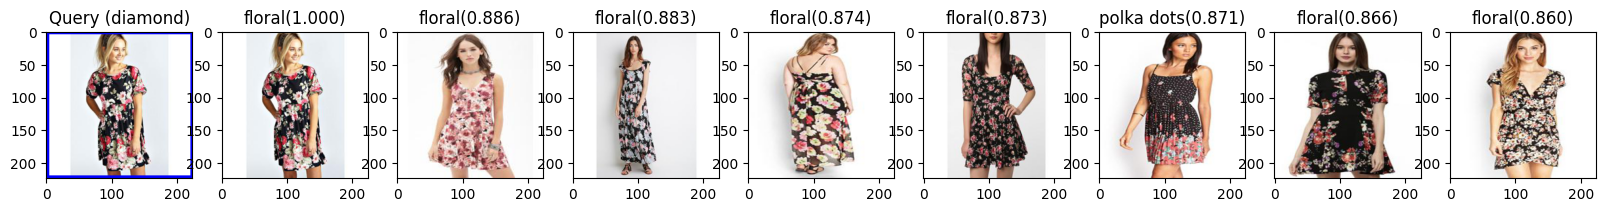

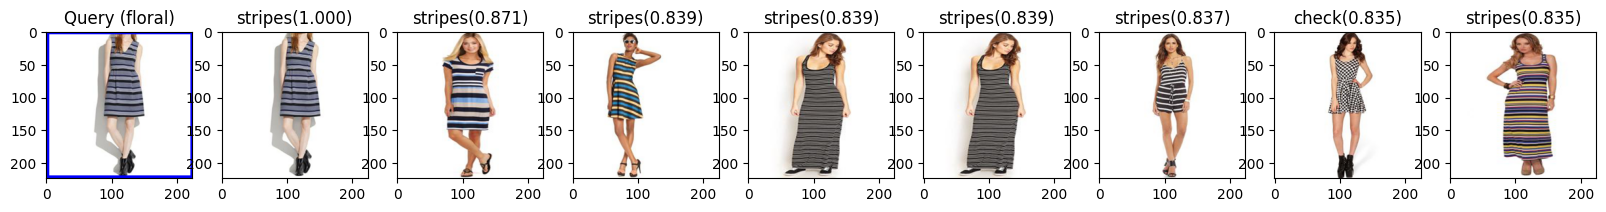

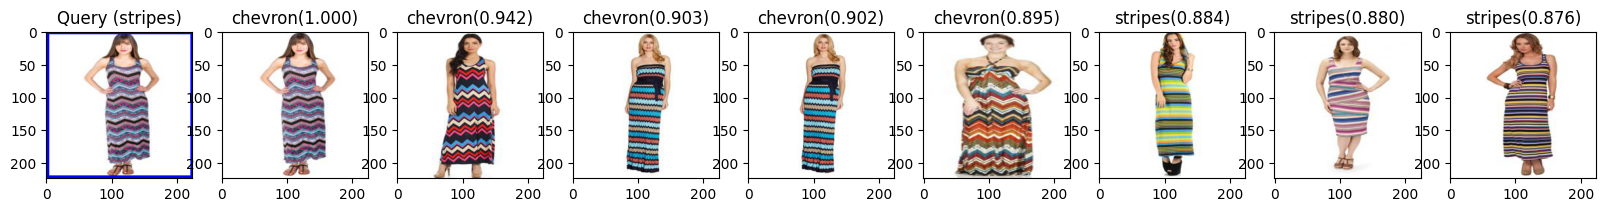

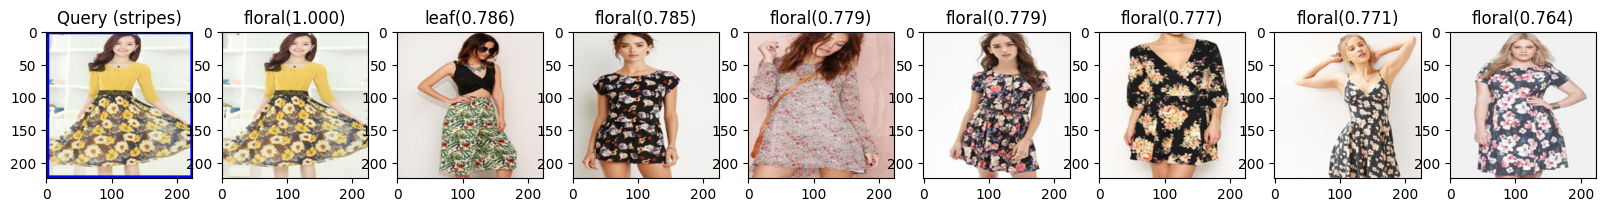

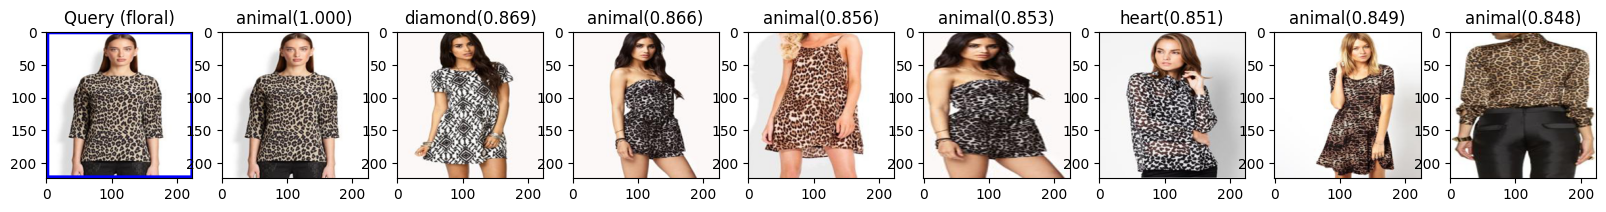

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 계산
num_show = 8
resize = (224,224)

for idx in selected_indices:
    query_feature = database_features[idx]
    database_features = np.array(database_features)
    similarities = cosine_similarity([query_feature], database_features)

    # 유사도가 높은 이미지 순으로 정렬
    similarities = similarities.squeeze()
    sorted_indices = np.argsort(similarities)[::-1]

    # 검색 결과 시각화
    fig, axes = plt.subplots(1, num_show+1, figsize=(20, 4))

    x = Image.open(database_filenames[idx]).resize(resize).convert('RGB')

    draw = ImageDraw.Draw(x)
    border_color = (0, 0, 255) # 파란색 (R,G,B)
    border_width = 5 # 테두리 두께
    image_width, image_height = x.size
    draw.rectangle((0, 0, image_width, image_height), outline=border_color, width=border_width)

    axes[0].imshow(x)
    axes[0].set_title(f'Query ({similar_image_path.split("/")[-2]})')
    for i in range(num_show):
        similar_image_path = database_filenames[sorted_indices[i]]
        similar_image = Image.open(similar_image_path).resize(resize).convert('RGB')
        score = similarities[sorted_indices[i]]
        axes[i+1].imshow(similar_image)
        axes[i+1].set_title(f'{similar_image_path.split("/")[-2]}({score:0.3f})')